 Pablo Chaves Tabares
 
 Universidad Nacional De Colombia
 Red Profunda y amplia (mnist fashion)
 
Sobre una base de datos con 10 clases se desea entrenar un sistema de redes neuronales artificial. El objetivo es usar un sistema para predecir 10 clases, es un problema de clasificacion, el sistema tiene dos salidas, una para prediccion de 10 clases, y otra salida de 3 clases para el genero de los objetos.

# Lectura

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler

#La base de datos por defecto contiene 60000 instancias para entrenamiento y 10000 instancias para probar
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.fashion_mnist.load_data()

#Preprocesamiento
print('Maximo valor de un pixel, es 2^8-1=:',np.amax(xtrain))
xtrain = xtrain/255 
xtest = xtest/255

print('train size:',xtrain.shape,', test size:', xtest.shape)


4423680/4422102 [==============================] - 0s 0us/step
Maximo valor de un pixel, es 2^8-1=: 255
train size: (60000, 28, 28) , test size: (10000, 28, 28)


tipo: <class 'tuple'> largo: 1 info: [18 32 33 39 40 55 56 72 77 95]


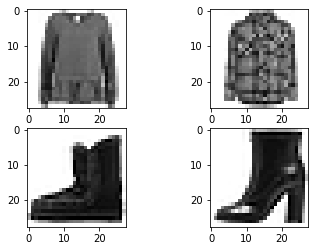

In [2]:
x=np.where(ytrain[:100]==6)
print('tipo:',type(x),'largo:',len(x),'info:',x[0])

import matplotlib.pyplot as plt
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)#0
ax1.imshow(xtrain[18],cmap='binary')
ax2.imshow(xtrain[32],cmap='binary')
ax3.imshow(xtrain[84],cmap='binary')
ax4.imshow(xtrain[88],cmap='binary')


# Creacion de etiquetas

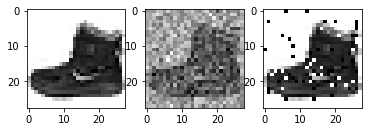

Cantidad de clases: 10


In [3]:
#Generamos las etiquetas de genero (Se observaron cuales son masculinas, femeninas y unisex mirando las imagenes con la etiqueta correspondiente)
#Masculino 1,2,6 #Femenino 3,5,8,9  #Unisex 7,4,0
#Masculino sera 0, Femenino 1, Unisex 2

ytraing=np.zeros(ytrain.shape[0])
ytestg=np.zeros(ytest.shape[0])
for p in range(0,ytrain.shape[0]):
    if ytrain[p]==1 or ytrain[p]==2 or ytrain[p]==6:
        a=0
    if ytrain[p]==3 or ytrain[p]==5 or ytrain[p]==8 or ytrain[p]==9:
        a=1
    if ytrain[p]==0 or ytrain[p]==4 or ytrain[p]==7:
        a=2
    ytraing[p]=a
for p in range(0,ytest.shape[0]):
    if ytest[p]==1 or ytest[p]==2 or ytest[p]==6:
        a=0
    if ytest[p]==3 or ytest[p]==5 or ytest[p]==8 or ytest[p]==9:
        a=1
    if ytest[p]==0 or ytest[p]==4 or ytest[p]==7:
        a=2
    ytestg[p]=a

#agregar entrada extra con AWGN
var = 0.1 #varianza del ruido
xtrainB = xtrain + np.sqrt(var)*np.random.randn(xtrain.shape[0],xtrain.shape[1],xtrain.shape[2])
xtestB = xtest + np.sqrt(var)*np.random.randn(xtest.shape[0],xtest.shape[1],xtest.shape[2])

#agregar entrada extra con ruido sal y pimienta a 0.9
from skimage.util import random_noise
xtrainS = np.zeros((xtrain.shape[0],xtrain.shape[1],xtrain.shape[2]))
xtestS = np.zeros((xtest.shape[0],xtest.shape[1],xtest.shape[2]))
for p in range (0,xtrain.shape[0]):
    xtrainS[p][:][:] = random_noise(xtrain[p], mode='s&p',amount=0.1)
for p in range (0,xtest.shape[0]):
    xtestS[p][:][:] = random_noise(xtest[p], mode='s&p',amount=0.1)

fig, ax = plt.subplots(1,3)
fig.figsize = (6,6)
ax[0].imshow(xtrain[0],cmap='binary')
ax[1].imshow(xtrainB[0],cmap='binary')
ax[2].imshow(xtrainS[0],cmap='binary')
plt.show()

unique=len(np.unique(ytrain))

print('Cantidad de clases:',unique)

genero: [1. 2. 2. 1. 2. 0. 2. 0. 1. 1.]
clase: [9 0 0 3 0 2 7 2 5 5]


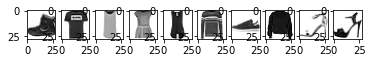

In [4]:
#Muestra de etiquetas segun genero
fig, ax = plt.subplots(1,10)
for p in range (0,10):
    ax[p].imshow(xtrain[p],cmap='binary')
print('genero:',ytraing[0:10])
print('clase:',ytrain[0:10])
#Masculino 1,2,6 #Femenino 3,5,8,9  #Unisex 7,4,0
#Masculino sera 0, Femenino 1, Unisex 2

# Modelo

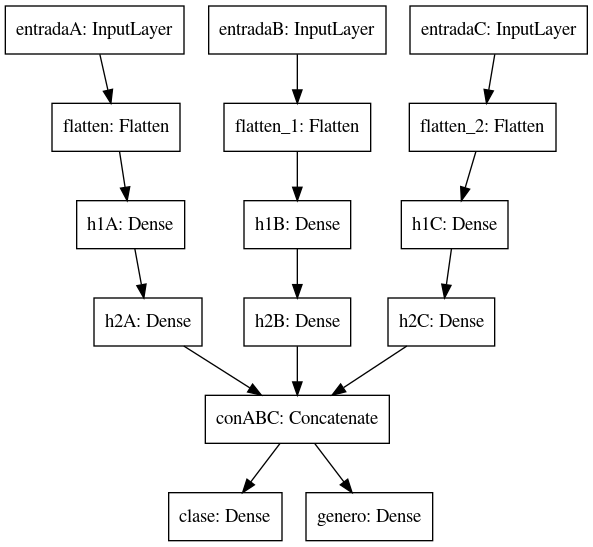

In [5]:
tf.keras.backend.clear_session()

inputA = tf.keras.layers.Input(shape=(xtrain.shape[1],xtrain.shape[2]), name='entradaA')#Entrada sin ruido
inputB = tf.keras.layers.Input(shape=(xtrainB.shape[1],xtrainB.shape[2]), name='entradaB')#Entrada con ruido gaussiano
inputC = tf.keras.layers.Input(shape=(xtrainS.shape[1],xtrainS.shape[2]), name='entradaC')#Entrada con ruido sal y pimienta

#Capas para aplanar
flattenA = tf.keras.layers.Flatten(input_shape=(xtrain.shape[1],xtrain.shape[2]))(inputA)
flattenB = tf.keras.layers.Flatten(input_shape=(xtrainB.shape[1],xtrainB.shape[2]))(inputB)
flattenC = tf.keras.layers.Flatten(input_shape=(xtrainS.shape[1],xtrainS.shape[2]))(inputC)

#Constantes de regularizacion
l1=1e-3
l2=1e-4

#La regularizacion l1 para cuando varios de los atributos de entrada (features) sean irrelevantes (Las esquinas), Complejidad=|w|
#La regularizacion l2 para cuando varios de los atributos de entrada (features) estan correlacionados (Las esquinas), Complejidad= w^2/2*N
h1A = tf.keras.layers.Dense(50,activation='relu',name='h1A',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenA)
h1B = tf.keras.layers.Dense(50,activation='relu',name='h1B',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenB)
h1C = tf.keras.layers.Dense(50,activation='relu',name='h1C',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(flattenC)
h2A = tf.keras.layers.Dense(20,activation='tanh',name='h2A',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(h1A)
h2B = tf.keras.layers.Dense(20,activation='tanh',name='h2B',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(h1B)
h2C = tf.keras.layers.Dense(20,activation='tanh',name='h2C',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(h1C)
concABC = tf.keras.layers.concatenate([h2A,h2B,h2C],name='conABC')
outputA = tf.keras.layers.Dense(10,activation="softmax",name='clase')(concABC)#salida multiclase
outputB = tf.keras.layers.Dense(3,activation="softmax",name='genero')(concABC) #salida multiclase genero
model_fun = tf.keras.Model(inputs=[inputA,inputB,inputC],outputs=[outputA,outputB])
tf.keras.utils.plot_model(model_fun)

#La activacion relu solo se activa si las entradas son positivas
#Salida A : 10 clases->10 neuronas tipo softmax
#Salida B : 3 clases->3 neuronas tipo softmax
#La activacion tanh permite una lenta convergencia
#Las activaciones softmax transformas las salidas para que la suma de todas ellas de 1 

# Compilar y entrenar

In [6]:
model_fun.compile(loss=[tf.keras.losses.SparseCategoricalCrossentropy(),tf.keras.losses.SparseCategoricalCrossentropy()]
                  ,loss_weights =[0.5,0.5] 
                  ,optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),metrics=["accuracy"])
history = model_fun.fit(x =[xtrain,xtrainB,xtrainS], y=[ytrain,ytraing], 
                        epochs=30,batch_size=64,
                        validation_split=0.3)
#La perdida de entropia cruzada es usada para clasificacion multiclase
#El optimizador Adam es eficiente, poco costoso, util para cuando hay buena cantidad de datos
#La tasa de aprendizaje se sintoniza para evitar la convergencia

Epoch 1/30
657/657 [==============================] - 3s 4ms/step - loss: 1.6814 - clase_loss: 0.7363 - genero_loss: 0.5060 - clase_accuracy: 0.7588 - genero_accuracy: 0.7872 - val_loss: 0.9386 - val_clase_loss: 0.6177 - val_genero_loss: 0.4708 - val_clase_accuracy: 0.7891 - val_genero_accuracy: 0.8012
Epoch 2/30
657/657 [==============================] - 2s 4ms/step - loss: 0.8308 - clase_loss: 0.5842 - genero_loss: 0.4234 - clase_accuracy: 0.7965 - genero_accuracy: 0.8267 - val_loss: 0.7774 - val_clase_loss: 0.5811 - val_genero_loss: 0.4071 - val_clase_accuracy: 0.7974 - val_genero_accuracy: 0.8366
Epoch 3/30
657/657 [==============================] - 3s 4ms/step - loss: 0.7173 - clase_loss: 0.5415 - genero_loss: 0.3893 - clase_accuracy: 0.8112 - genero_accuracy: 0.8413 - val_loss: 0.7013 - val_clase_loss: 0.5623 - val_genero_loss: 0.3715 - val_clase_accuracy: 0.7881 - val_genero_accuracy: 0.8511
Epoch 4/30
657/657 [==============================] - 2s 4ms/step - loss: 0.6703 - clase

Epoch 28/30
657/657 [==============================] - 2s 4ms/step - loss: 0.5191 - clase_loss: 0.4447 - genero_loss: 0.3187 - clase_accuracy: 0.8442 - genero_accuracy: 0.8720 - val_loss: 0.5260 - val_clase_loss: 0.4567 - val_genero_loss: 0.3222 - val_clase_accuracy: 0.8423 - val_genero_accuracy: 0.8726
Epoch 29/30
657/657 [==============================] - 2s 4ms/step - loss: 0.5173 - clase_loss: 0.4430 - genero_loss: 0.3179 - clase_accuracy: 0.8447 - genero_accuracy: 0.8720 - val_loss: 0.5324 - val_clase_loss: 0.4513 - val_genero_loss: 0.3382 - val_clase_accuracy: 0.8418 - val_genero_accuracy: 0.8648
Epoch 30/30
657/657 [==============================] - 2s 4ms/step - loss: 0.5179 - clase_loss: 0.4436 - genero_loss: 0.3173 - clase_accuracy: 0.8470 - genero_accuracy: 0.8732 - val_loss: 0.5449 - val_clase_loss: 0.4757 - val_genero_loss: 0.3405 - val_clase_accuracy: 0.8287 - val_genero_accuracy: 0.8588


# Curvas de aprendizaje

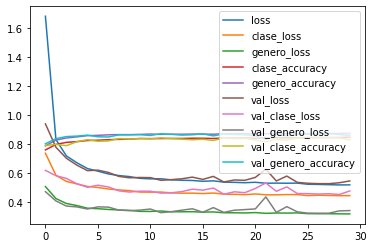

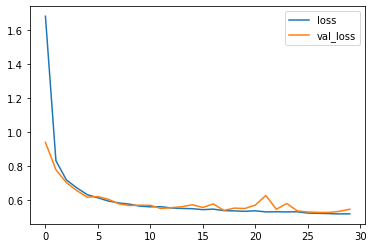

In [7]:
import pandas as pd
hpd = pd.DataFrame(history.history)
hpd.plot()
plt.show()
hpd[['loss','val_loss']].plot()
plt.show()

# Pesos
Cumplen una funcion muy importante, es posible observar en la red, que prioridad esta dando a cada uno de los atributos de la entrada del sistema

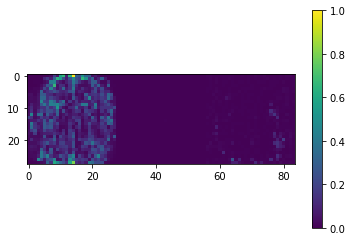

In [8]:
W1 = abs(model_fun.get_layer('h1A').get_weights()[0]).sum(axis=1).reshape(xtest.shape[1],xtest.shape[2])
W2 = abs(model_fun.get_layer('h1B').get_weights()[0]).sum(axis=1).reshape(xtest.shape[1],xtest.shape[2])
W3 = abs(model_fun.get_layer('h1C').get_weights()[0]).sum(axis=1).reshape(xtest.shape[1],xtest.shape[2])
Wc = np.c_[W1,W2,W3]
Wc /=np.max(Wc)
plt.imshow(Wc,vmin=0,vmax=1)
plt.colorbar()
plt.show()

Se observan los pesos de la primera capa, para los pesos de las distintas entradas

# Matrices de confusion y metricas

(10000, 10)
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      1000
           1       1.00      0.95      0.97      1000
           2       0.73      0.69      0.71      1000
           3       0.83      0.87      0.85      1000
           4       0.79      0.57      0.66      1000
           5       0.94      0.90      0.92      1000
           6       0.47      0.70      0.57      1000
           7       0.90      0.94      0.92      1000
           8       0.92      0.96      0.94      1000
           9       0.94      0.92      0.93      1000

    accuracy                           0.82     10000
   macro avg       0.84      0.82      0.82     10000
weighted avg       0.84      0.82      0.82     10000

tamaño clase prueba (10000,)
tamaño clase predicha (10000, 10)
tamaño genero prueba  (10000,)
tamaño genero predicho (10000, 3)


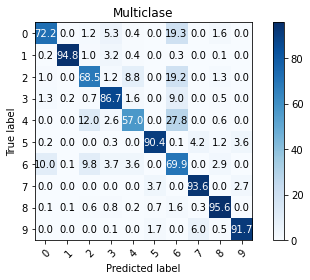

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

ytest_e,ytest_eG = model_fun.predict([xtest,xtestB,xtestS])
print(ytest_e.shape)
plot_confusion_matrix(ytest, ytest_e.argmax(axis=1),classes=np.unique(ytest))
plt.title('Multiclase')
print(classification_report(ytest, ytest_e.argmax(axis=1)))

print('tamaño clase prueba',ytest.shape)
print('tamaño clase predicha',ytest_e.shape)
print('tamaño genero prueba ',ytestg.shape)
print('tamaño genero predicho',ytest_eG.shape)



Se observa en general un muy buen funcionamiento de la red en 8 de las 10 clases.

La clase 6 son las camisas por ende, tienden a confudirse con la clase 4 (abrigos), la clase 2 (busos), y la clase 0 (t-shirt)

              precision    recall  f1-score   support

         0.0       0.76      0.90      0.82      3000
         1.0       0.93      0.93      0.93      4000
         2.0       0.86      0.70      0.77      3000

    accuracy                           0.85     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.86      0.85      0.85     10000



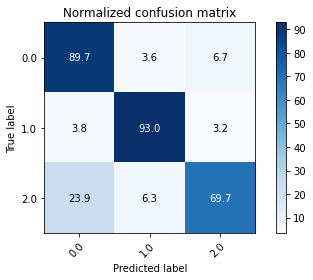

In [10]:
plot_confusion_matrix(ytestg, ytest_eG.argmax(axis=1),classes=np.unique(ytestg))
print(classification_report(ytestg ,ytest_eG.argmax(axis=1)))

Esta es la matriz de confusion de la salida del genero, para el caso de la etiqueta 2 (unisex), hay una ligera deficiencia.

# Ejemplo de prediccion y aplicacion del sistema

clase: 3 Genero: 1


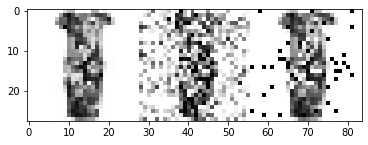

In [11]:
ii = 100
pe,peb = model_fun.predict([xtest[ii][np.newaxis,:,:],xtestB[ii][np.newaxis,:,:],xtestS[ii][np.newaxis,:,:]])
print('clase:',pe.argmax(),'Genero:',peb.argmax())
plt.imshow(np.c_[xtest[ii],xtestB[ii],xtestS[ii]],cmap='binary',vmin=0,vmax=1)
plt.show()

El sistema arroja dos salidas, la clase y el genero. Para este caso se observa la imagen que se le ingreso al sistema. Acertó.